In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

In [2]:
yf = yf.download(["SLV", "GDX", "GLD"], start = '2011-08-01', end='2012-05-30')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


In [3]:
gdx, gld, slv = yf.to_numpy()[:200, 0], yf.to_numpy()[:200, 1], yf.to_numpy()[:200, 2]

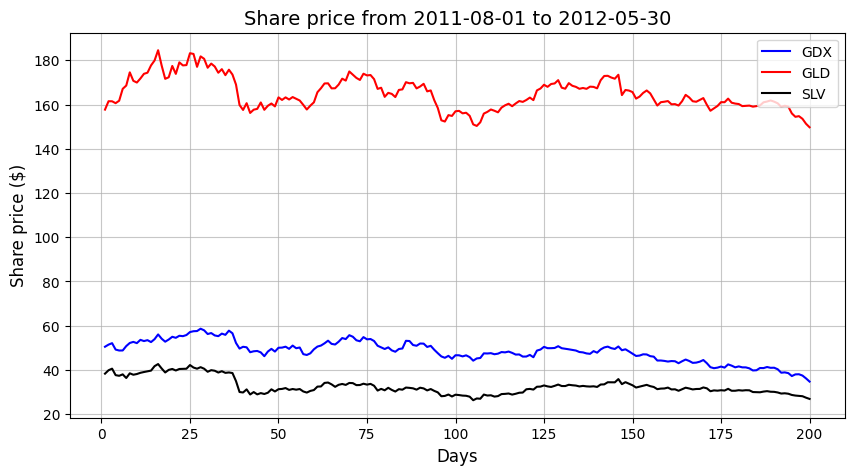

In [110]:
plt.figure(figsize=(10, 5))

x_vals = np.linspace(1, 200, 200)
plt.plot(x_vals, gdx, color='blue', label='GDX')
plt.plot(x_vals, gld, color='red', label='GLD')
plt.plot(x_vals, slv, color='black', label='SLV')
plt.grid(True, alpha=0.7)
plt.title('Share price from 2011-08-01 to 2012-05-30', fontsize=14)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Share price ($)', fontsize=12)
plt.legend(loc='upper right')

In [5]:
def likelihood(sigma, mu, theta, dt, N, X):
    sigma_tilde = np.sqrt(sigma**2 * (1 - np.exp(-2*mu*dt))/(2 * mu))
    
    const1 = -1/2 * np.log(2*np.pi)
    const2 = -np.log(sigma_tilde)

    factor = -1/(2*N*sigma_tilde**2)

    sum = 0

    for i in range(1,N):
        sum = sum + (X[i] - X[i-1] * np.exp(-mu*dt) - theta*(1-np.exp(-mu*dt)))**2

    return const1 + const2 + factor*sum

In [6]:
def parameters(X, N, dt):
    Xx = np.sum(X[:N-1])
    Xy = np.sum(X[1:N])
    Xxx = np.sum((X[:N-1])**2)
    Xxy = np.sum(X[:N-1]*X[1:N])
    Xyy = np.sum((X[1:N])**2)

    theta_star = (Xy*Xxx - Xx * Xxy) / (N * (Xxx - Xxy) - (Xx**2 - Xx * Xy))
    mu_star = -1/dt * np.log( (Xxy - theta_star * Xx - theta_star * Xy + N * (theta_star)**2) / (Xxx - 2 * theta_star * Xx + N*(theta_star)**2) )
    sigma_star_sqrd = 2 * mu_star / ( N * (1 - np.exp(-2*mu_star*dt)))  *  (Xyy - 2 * np.exp(-mu_star*dt) * Xxy + np.exp(-2 * mu_star * dt)*Xxx - \
                                                                           2 * theta_star * (1 - np.exp(-mu_star * dt)) * (Xy - np.exp(-mu_star*dt)*Xx) + \
                                                                           N * (theta_star)**2 * (1 - np.exp(-mu_star * dt))**2)  
    sigma_star = np.sqrt(sigma_star_sqrd)
    return theta_star, mu_star, sigma_star

In [76]:
dt = 1/252

B_over_A = np.linspace(0.001, 1, 10000)
likelihood_array_gdx = np.array([])
likelihood_array_slv = np.array([])

N = gdx.size

for val in B_over_A: 
    alpha = 1/gld[0]
    beta = val/gdx[0]
    X = alpha * gld - beta * gdx
    theta1, mu1, sigma1 = parameters(X, N ,dt)
    likelihood_array_gdx = np.append(likelihood_array_gdx, likelihood(sigma1, mu1, theta1, dt, N, X))

for val in B_over_A: 
    alpha = 1/gld[0]
    beta = val/slv[0]
    X = alpha * gld - beta * slv
    theta1, mu1, sigma1 = parameters(X, N ,dt)
    likelihood_array_slv = np.append(likelihood_array_slv, likelihood(sigma1, mu1, theta1, dt, N, X))

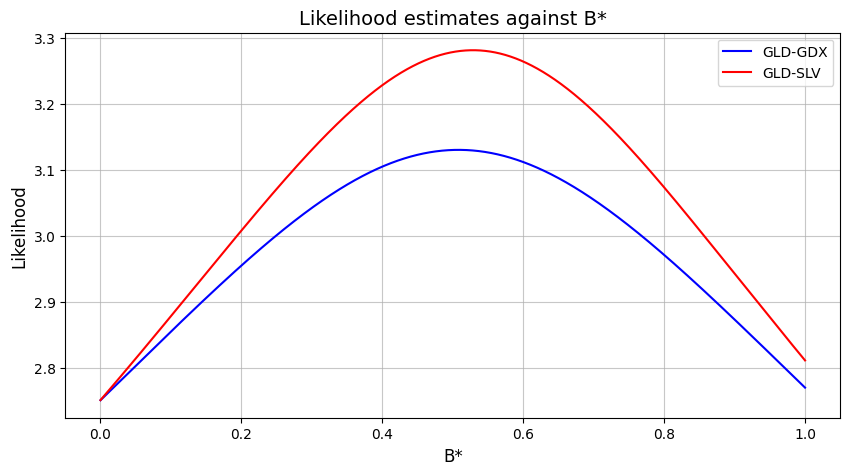

In [80]:
plt.figure(figsize=(10, 5))

plt.plot(B_over_A, likelihood_array_gdx, color='blue', label='GLD-GDX')
plt.plot(B_over_A, likelihood_array_slv, color='red', label='GLD-SLV')

plt.grid(True, alpha=0.7)
plt.title('Likelihood estimates against B*', fontsize=14)
plt.ylabel('Likelihood', fontsize=12)
plt.xlabel('B*', fontsize=12)
plt.legend(loc='upper right')

Text(0.5, 0, 'Days')

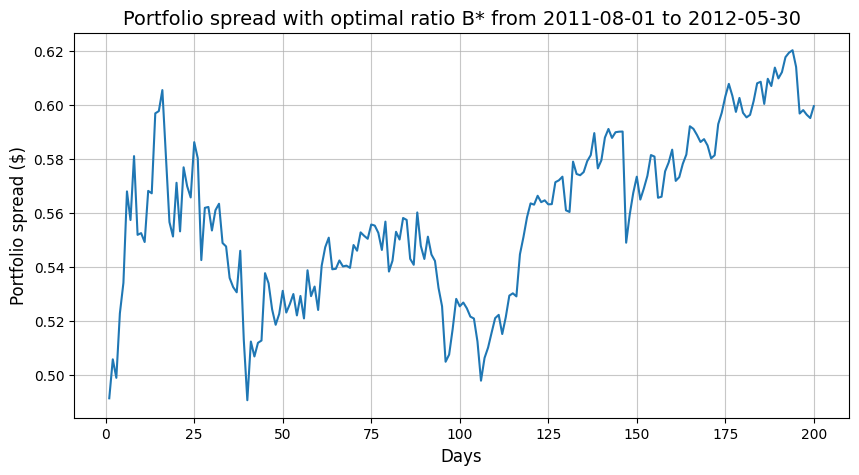

In [113]:
ind_gdx = np.where(likelihood_array_gdx == np.max(likelihood_array_gdx))
opt_ratio = B_over_A[ind_gdx][0]

alpha, beta = 1/gld[0], opt_ratio/gdx[0]

X_opt = alpha * gld - beta * gdx

plt.figure(figsize=(10, 5))
plt.plot(x_vals, X_opt)
plt.grid(True, alpha=0.7)
plt.title('Portfolio spread with optimal ratio B* from 2011-08-01 to 2012-05-30', fontsize=14)
plt.ylabel('Portfolio spread ($)', fontsize=12)
plt.xlabel('Days', fontsize=12)